In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import datetime
import subprocess
sns.set(context = 'notebook', style = 'ticks')
%matplotlib inline


## Summary

The Allen brain atlas has a publicly available dataset that has sequenced 4 brain regions of 51 patients with dementia/alzheimers (dsm iv diagnoses) and 55 healthy controls. Each donor contributes to several different brain regions. They provide normalized and non-normalized fragments per kilobases per million values (FPKM).

To analyze this cohort, I designated all forms of dementia as "cases" and those that did not exhibit dementia as "controls". I chose to use the normalized FPKM values that have likely been normalized relative to the reads. I can redo this with the non-normalized as well, if we want to switch to TPM, but for now, normalized. 

Then I subsetted the RNAseq to the genes that were of interest on the network. 

First let's look at the cohort characteristics

In [5]:
#Load gene expression
gene_expr = pd.read_csv('data_files/alzheimers/fpkm_table_normalized.csv', header = 0, index_col = 0)
gene_expr.columns = [int(x) for x in gene_expr.columns]
gene_expr.index = [int(x) for x in gene_expr.index]

In [6]:
#Load patient metadata
fin = 'data_files/alzheimers/DonorInformation.csv'
donor_table = pd.read_csv(fin, sep = ',', header = 0, index_col = 0)

fin = 'data_files/alzheimers/columns-samples.csv'
column_info = pd.read_csv(fin, sep = ',', header = 0, index_col = 0)

fin = 'data_files/alzheimers/rows-genes.csv'
row_info = pd.read_csv(fin, sep = ',', header = 0, index_col = 0)

donor_info_map = column_info.loc[gene_expr.columns,'donor_id']
diax = donor_table.loc[donor_info_map.unique(),'dsm_iv_clinical_diagnosis']
specimen_info = column_info.loc[gene_expr.columns,'structure_name']

In [8]:
#Map the donor info onto the column info of the gene expression dataset
donor_info_map = column_info.loc[gene_expr.columns,'donor_id']
diax = donor_table.loc[donor_info_map.unique(),'dsm_iv_clinical_diagnosis']
specimen_info = column_info.loc[gene_expr.columns,'structure_name']

#Assign case and control
diax_use_codes = diax.unique()
diax_use = diax[diax.isin(diax_use_codes)]

use_column_info = column_info[column_info['donor_id'].isin(diax_use.index)].copy(deep=True)
use_gene_expr = gene_expr[use_column_info.index]

#Assign case control status
map_diax = diax_use.map({x:['Case','Control'][x=="No Dementia"] for x in diax_use.unique()})
use_column_info['CaseStatus'] =use_column_info['donor_id'].map(map_diax)

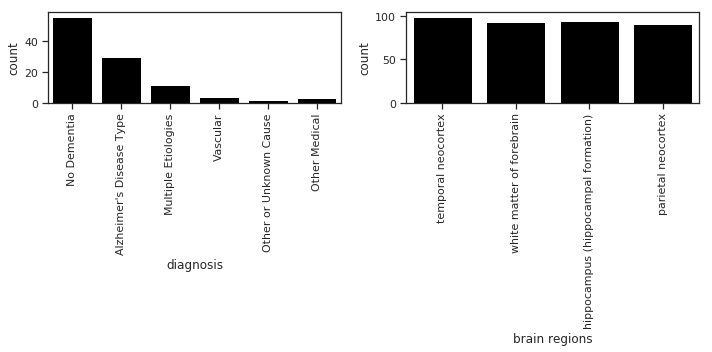

In [23]:
#These are the diagnonses & the number of each kind

f, axes = plt.subplots(1,2,figsize=(10,5))
labs = ['diagnosis','brain regions']
for i,y in enumerate([diax, specimen_info]):
    ax = sns.countplot(y, ax = axes[i], color = 'black', orient='h')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel(labs[i])
f.tight_layout()
plt.show()
plt.close()

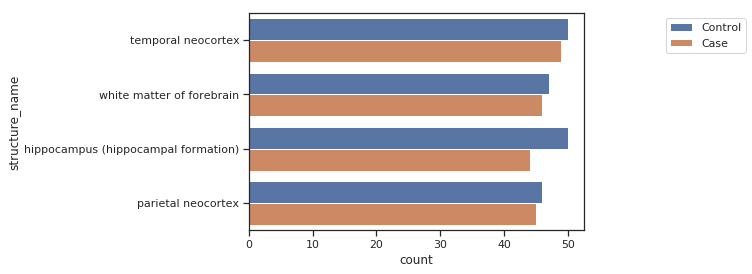

In [10]:
#Counting the number of sequencing profiles from each brain region that are case and control
ax = sns.countplot(y='structure_name',hue='CaseStatus',data=use_column_info)
ax.legend(bbox_to_anchor=(1.5,1))
plt.show()
plt.close()

In [11]:
#Look at age..
age_lab = ['100+','77', '78', '79', '81', '82', '83', '84', '85', '86', '87', '88',
 '89', '90-94', '95-99']
age_cat =['-100', '77-81', '77-81', '77-81', '82-84', '82-84', '82-84', '85-89',
 '85-89', '85-89', '85-89', '85-89', '85-89', '90-94', '95-99'] 
agecatint = [int(x.split('-')[1]) for x in age_cat]
map_age2cat = {x:y for x,y in zip(age_lab, agecatint)}

use_column_info['Age'] = use_column_info['donor_id'].map(donor_table['age'])
use_column_info['AgeC']=use_column_info['Age'].map(map_age2cat)

['100+', '77', '78', '79', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90-94', '95-99']


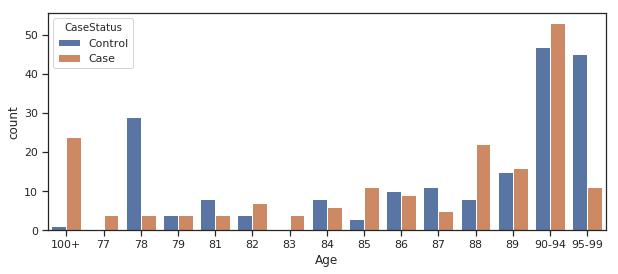

In [21]:
#These represent the given ages
print(sorted(age_lab))
f,ax = plt.subplots(1,1,figsize=(10,4))
sns.countplot(x=use_column_info['Age'], hue = use_column_info['CaseStatus'], order = sorted(age_lab),ax=ax)
plt.show()
plt.close()

['-100' '77-81' '82-84' '85-89' '90-94' '95-99']


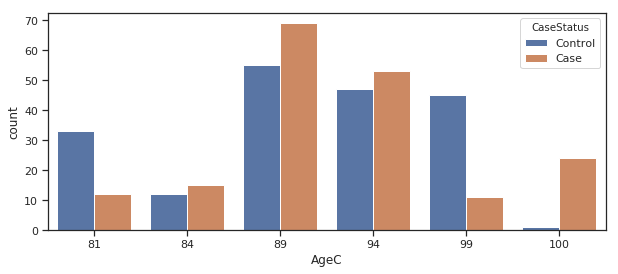

In [19]:
#These represent the unique age categories above, 
print(np.unique(age_cat))
f,ax = plt.subplots(1,1,figsize=(10,4))
sns.countplot(x=use_column_info['AgeC'], hue = use_column_info['CaseStatus'], order = np.unique(agecatint),ax=ax)
plt.show()
plt.close()

## Testing association seperately for each brain region

First, let's look at the average expression of our network genes relative to all other genes for each brain region.

In [36]:
#Load network genes
outf = 'data_files/190814_CompositePCNet_union_ncl_genes.txt'
compnu_allgenes = pd.read_csv(outf, sep = '\t',header=None, index_col = None)
networkgenes = np.unique(compnu_allgenes.values.ravel())

allother_genes_rnaid = row_info.loc[~row_info['gene_symbol'].isin(networkgenes)].index
network_genes_rnaid = row_info[row_info['gene_symbol'].isin(networkgenes)].index

#Transform gene expression to log2 scale (+pseudocount of 1)
pc=1
use_gene_expr_xf = use_gene_expr.apply(lambda x: np.log2(x+pc))


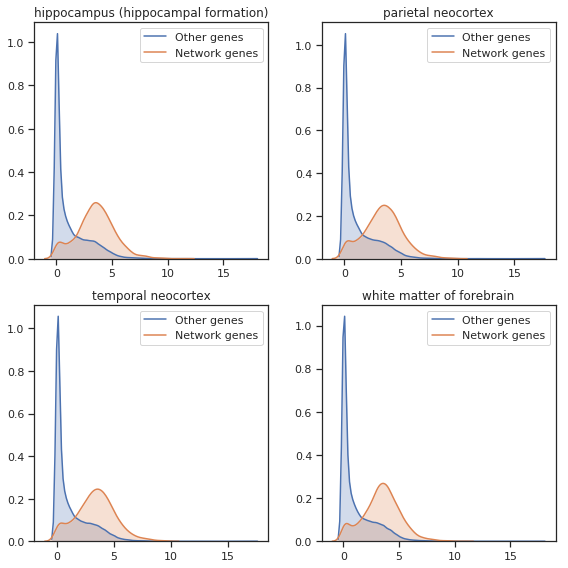

In [38]:
f, axes = plt.subplots(2,2,figsize=(8,8))
cc = sns.color_palette()

for ax,(k,grp) in zip(axes.flatten(),use_gene_expr_xf.groupby(use_column_info['structure_name'], axis=1)):
    for i, geneuse in enumerate([allother_genes_rnaid,network_genes_rnaid]):
        sns.kdeplot(grp.loc[geneuse].mean(axis=1), 
                    label = ['Other genes','Network genes'][i], color = cc[i], ax = ax,
                   shade=True)
    ax.set_title(k)
f.tight_layout()
plt.show()
plt.close()
#sns.violinplot()

We can see that they're decently expressed relative to all other genes, but not necessarily the most expressed.

Then, I decided to test for differential expression between case and control by fitting models that considered each brain region seperately or combined. These are the following formuals:

 (1) Expr = Age + CaseControl -- I refer to this as 'separate regressions'<br>
<br>
 (2) Expr = Age + CaseControl + Brain_region -- I refer to this as 'single regression'<br>
 <br>
 
The pvalue of the association of CaseControl were taken and corrected according to Benjami-Hochberg to control for FDR. 

In [40]:
outf = 'data_files/190821_NetworkGenes_SepRegPerBrainRegion.txt'
sepreg_results_table = pd.read_csv(outf, sep = '\t', header = 0, index_col=None)

outf = 'data_files/190821_NetworkGenes_SingleRegressionAllBrainRegions.txt'
singlereg_results_table = pd.read_csv(outf, sep = '\t', header = 0, index_col=None)

plot_dict = {'Single':singlereg_results_table, 'Separate':sepreg_results_table}

In [41]:
sepreg_results_table.head()

,gene_id,effect size,pval,fdr_bh,BrainRegion
0,499304707,0.052731,0.232917,0.797068,hippocampus (hippocampal formation)
1,499304714,-0.303941,0.070220,0.785772,hippocampus (hippocampal formation)
2,499304715,-0.077294,0.304356,0.820504,hippocampus (hippocampal formation)
3,499304730,-0.004225,0.913254,0.982940,hippocampus (hippocampal formation)
4,499304733,0.043264,0.282227,0.811876,hippocampus (hippocampal formation)


Lets explore the results


Single
235 unique significant genes at 0.125 FDR
Plotting top 10 most significant


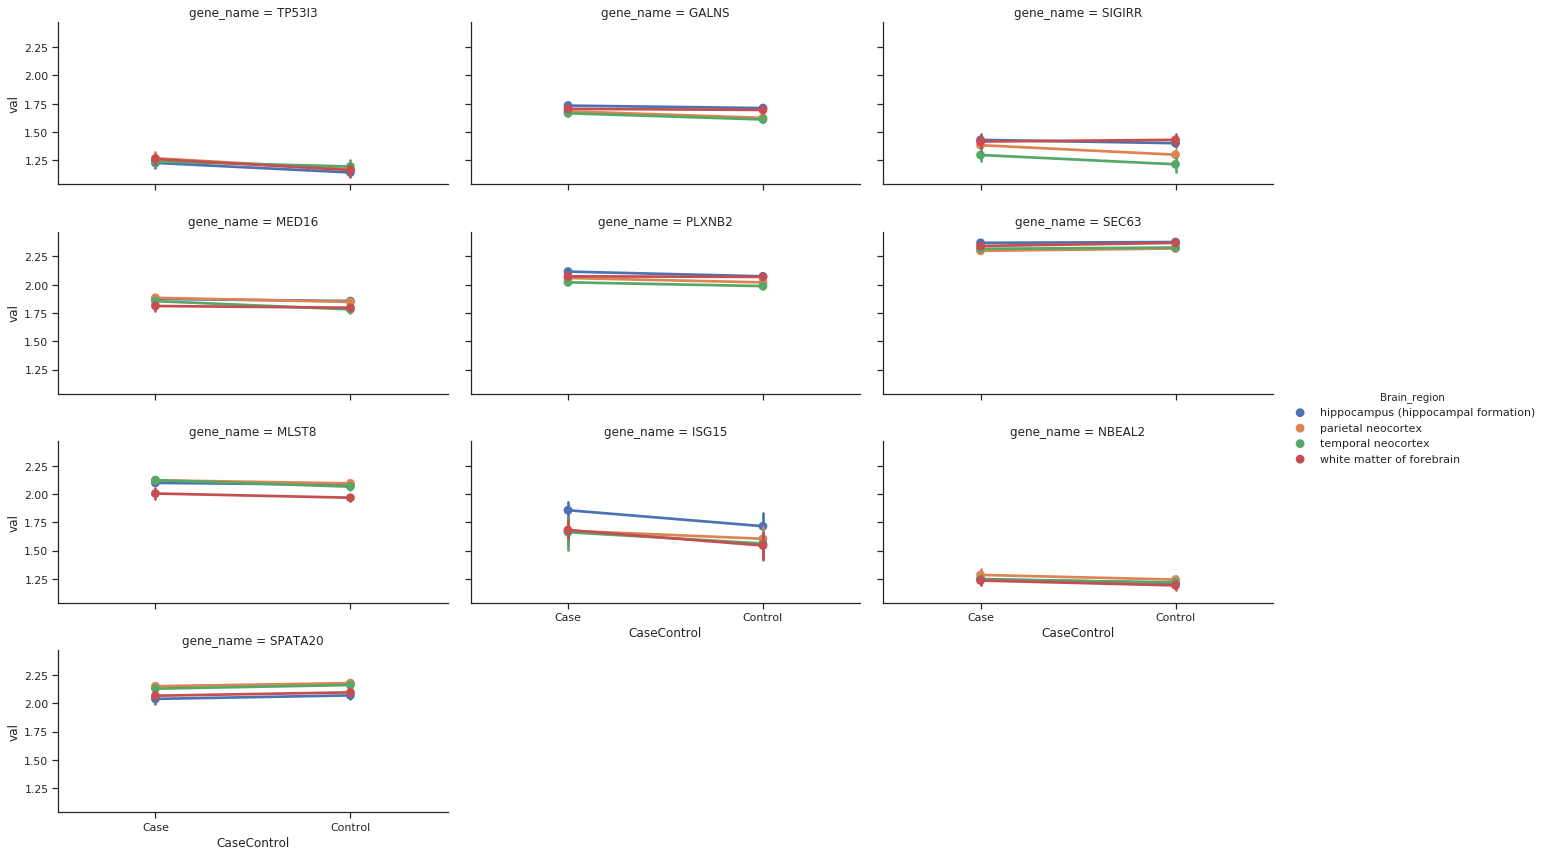


Separate
256 unique significant genes at 0.2 FDR
in temporal neocortex
Plotting top 10 most significant


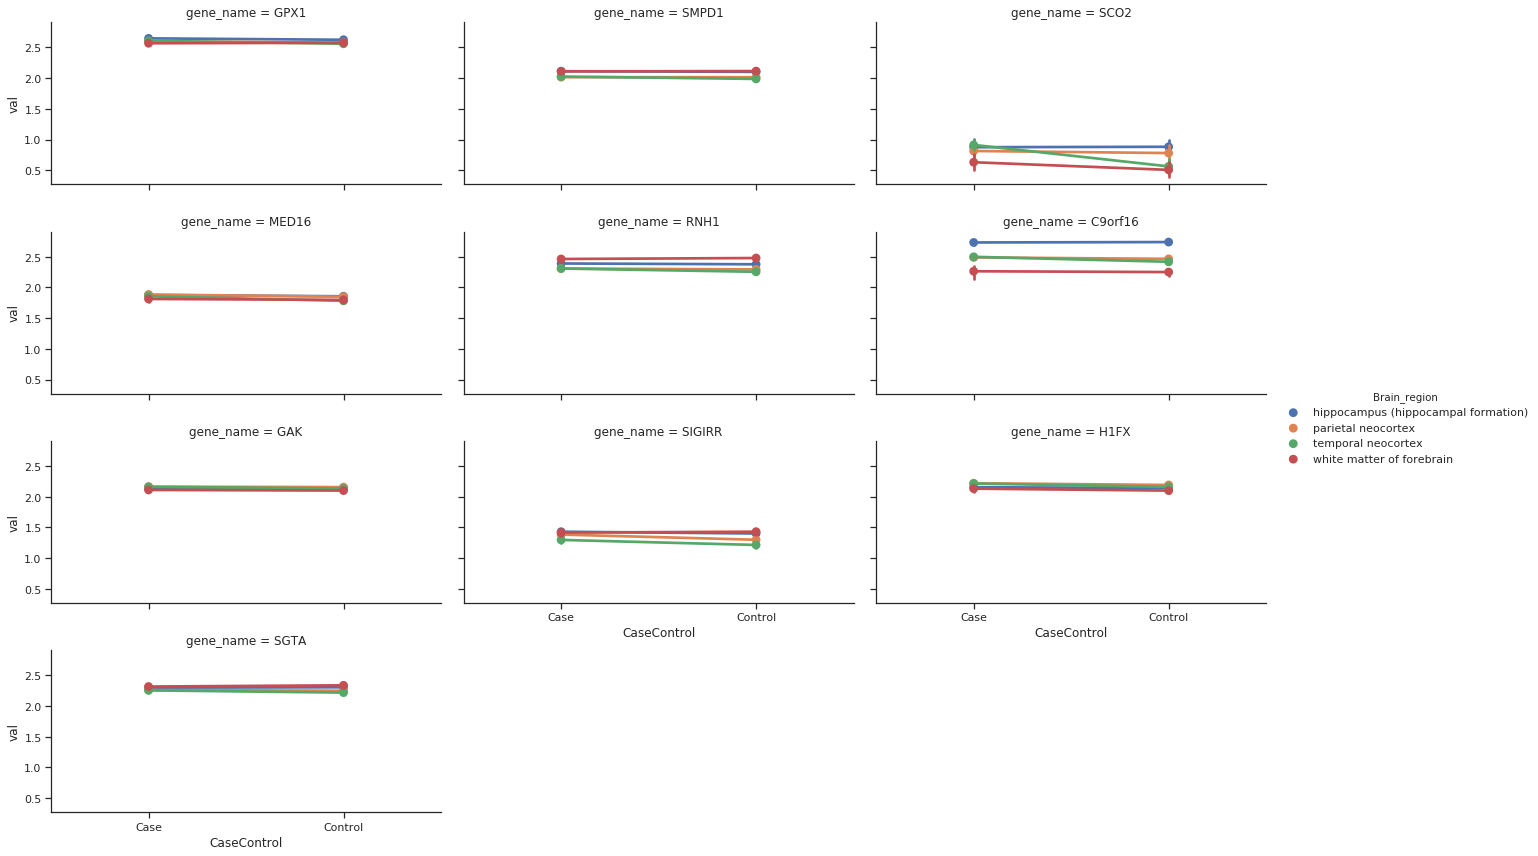

In [55]:
cutoff_map = {'Single':0.125,'Separate':0.2}
for regtype, results_table in plot_dict.items():
    results_table['gene_name'] = results_table['gene_id'].map(row_info['gene_symbol'])
    cutoff = cutoff_map[regtype]
    sig_results = results_table[results_table['fdr_bh']<cutoff]
    print('\n'+regtype)
    print('{} unique significant genes at {} FDR'.format(sig_results['gene_id'].unique().shape[0], cutoff))
    if regtype == 'Separate':
        print('in {}'.format(sig_results['BrainRegion'].unique()[0]))
    #    use_tissue_id = use_column_info[use_column_info['structure_name'].isin(sig_results['BrainRegion'].unique())].sort_values(by='structure_name').index
    #else:
    print('Plotting top 10 most significant')
    use_tissue_id = use_column_info.sort_values(by='structure_name').index
    ttgenes = sig_results.sort_values(by='fdr_bh')['gene_id'][:10]
    tsig_genes_expr = use_gene_expr_xf.loc[ttgenes,use_tissue_id].T.reset_index()
    tsig_genes_expr['CaseControl'] = tsig_genes_expr['rnaseq_profile_id'].map(use_column_info['CaseStatus'])
    ttdf = tsig_genes_expr.melt(id_vars=['CaseControl','rnaseq_profile_id'])
    ttdf['val'] = (ttdf['value']+pc).apply(lambda x: np.log2(x))
    ttdf['Brain_region'] = ttdf['rnaseq_profile_id'].map(use_column_info['structure_name'])
    ttdf['gene_name'] = ttdf['variable'].map(row_info['gene_symbol'])
    
    g = sns.catplot(hue='Brain_region',x='CaseControl',y='val',col='gene_name',col_wrap=3,
                    data=ttdf, ci=95, kind = 'point', height = 3, aspect = 2)
    plt.show()
    plt.close()

Single regression finds genes with a consistent change over all brain regions, whereas seperate is kind of all over the place except for some in the temporal neocortex. 

These results are summarized in the dropbox excel.